<a href="https://colab.research.google.com/github/IA2021UR/trabajo-ia-en-la-comunidad-de-la-rioja-equipo-3/blob/main/Aplicacion_Panoramicas_Automaticas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     |████████████████████████████████| 204kB 6.8MB/s 
     |████████████████████████████████| 61kB 5.9MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61



Archive:  fotos.zip
  inflating: fotos/1.jpg             
  inflating: fotos/2.jpg             


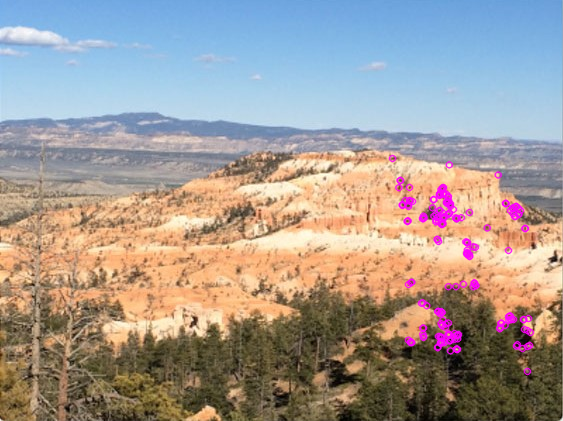

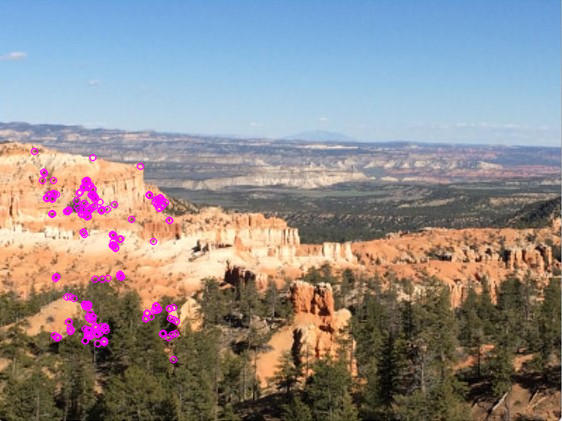

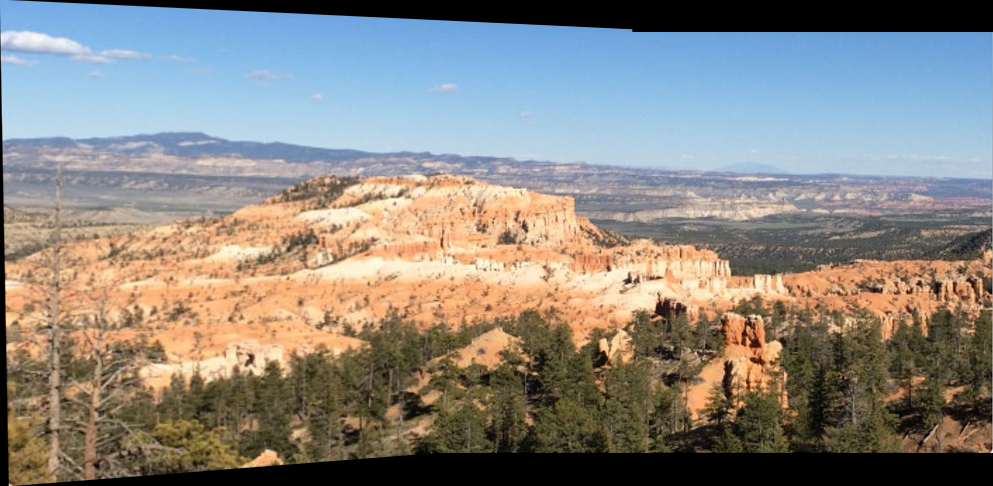




Archive:  fotos.zip
   creating: fotos/
  inflating: fotos/1.jpg             
  inflating: fotos/2.jpg             


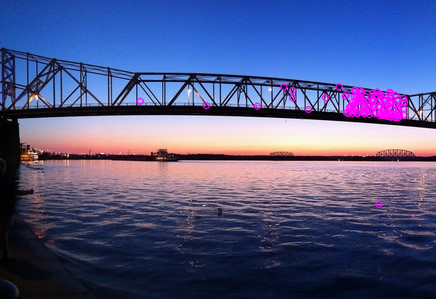

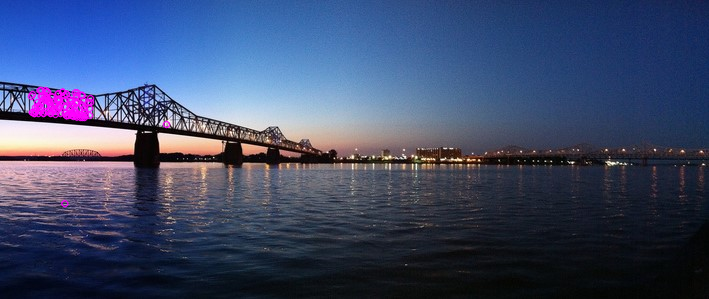

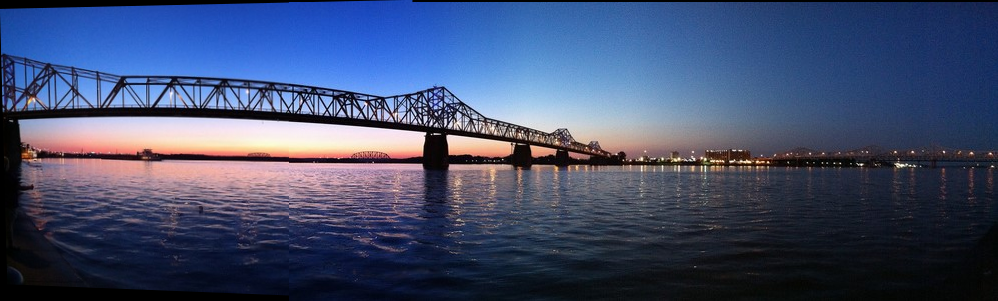

In [1]:
#@title Selecciona un fichero .ZIP llamado fotos con dos imágenes dentro de una carpeta llamada fotos (las imágenes deben estar en formato JPG y llamarse 1 -la izquierda- y 2 -la derecha-)

!pip install fastai --upgrade

###

from fastai.vision.all import *
import os
import zipfile
from google.colab import files
from sklearn.model_selection import train_test_split
import shutil
from fastai.vision.all import *
from fastai.vision.widgets import *
import cv2
from google.colab.patches import cv2_imshow

###

def draw_matches(rotada1, keypoints1, rotada2, keypoints2, matches):
    r, c = rotada1.shape[:2]
    r1, c1 = rotada2.shape[:2]

    # Create a blank image with the size of the first image + second image
    output_img = np.zeros((max([r, r1]), c+c1, 3), dtype='uint8')
    output_img[:r, :c, :] = np.dstack([rotada1, rotada1, rotada1])
    output_img[:r1, c:c+c1, :] = np.dstack([rotada2, rotada2, rotada2])

    # Go over all of the matching points and extract them
    for match in matches:
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx
        (x1, y1) = keypoints1[img1_idx].pt
        (x2, y2) = keypoints2[img2_idx].pt

        # Draw circles on the keypoints
        cv2.circle(output_img, (int(x1),int(y1)), 4, (0, 255, 255), 1)
        cv2.circle(output_img, (int(x2)+c,int(y2)), 4, (0, 255, 255), 1)

        # Connect the same keypoints
        cv2.line(output_img, (int(x1),int(y1)), (int(x2)+c,int(y2)), (0, 255, 255), 1)
    
    return output_img

###

def warpImages(img1, img2, H):

    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]

    list_of_points_1 = np.float32([[0,0], [0, rows1], [cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    temp_points = np.float32([[0, 0], [0, rows2], [cols2, rows2], [cols2, 0]]).reshape(-1, 1, 2)

    # When we have established a homography we need to warp perspective
    # Change field of view
    list_of_points_2 = cv2.perspectiveTransform(temp_points, H)

    list_of_points = np.concatenate((list_of_points_1, list_of_points_2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  
    translation_dist = [-x_min, -y_min]
  
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

    output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
    output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

    return output_img

###

def stitch(img1, img2):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    # Create our ORB detector and detect keypoints and descriptors
    orb = cv2.ORB_create(nfeatures=2000)

    # Find the key points and descriptors with ORB
    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)
    img1KeyPoints=cv2.drawKeypoints(img1, keypoints1, None, (255, 0, 255))
    img2KeyPoints=cv2.drawKeypoints(img2, keypoints2, None, (255, 0, 255))
    # Create a BFMatcher object.
    # It will find all of the matching keypoints on two images
    bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)

    # Find matching points
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    all_matches = []
    for m, n in matches:
        all_matches.append(m)

    img3 = draw_matches(img1_gray, keypoints1, img2_gray, keypoints2, all_matches[:30])
    # Finding the best matches
    good = []
    for m, n in matches:
        if m.distance < 0.6 * n.distance:
            good.append(m)
    cv2_imshow(cv2.drawKeypoints(img1, [keypoints1[m.queryIdx] for m in good], None, (255, 0, 255)))
    cv2_imshow(cv2.drawKeypoints(img2, [keypoints2[m.trainIdx] for m in good], None, (255, 0, 255)))
    MIN_MATCH_COUNT = 10

    if len(good) > MIN_MATCH_COUNT:
        # Convert keypoints to an argument for findHomography
        src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        # Establish a homography
        M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        result = warpImages(img2, img1, M)

        cv2_imshow(result)

###

btn_upload=widgets.FileUpload()
out_pl=widgets.Output()
lbl_pred=widgets.Label()

###

def on_data_change(change):
    lbl_pred.value =''

    out_pl.clear_output()
    fotos = btn_upload.data[-1]

    with open('fotos.zip', 'wb') as writefile:
        writefile.write(fotos)
    try:
        shutil.rmtree("fotos")
        print('\n\n')
    except:
        print('')
    !unzip fotos
    img1 = cv2.imread("fotos/1.jpg")
    img2 = cv2.imread("fotos/2.jpg")

    lbl_pred.value=f'Resultado:'
    stitch(img1, img2)

###

btn_upload.observe(on_data_change, names=['data'])
display(VBox([widgets.Label('Selecciona un fichero .ZIP llamado fotos con dos imágenes dentro de una carpeta llamada fotos (las imágenes deben estar en formato JPG y llamarse 1 -la izquierda- y 2 -la derecha-).'),btn_upload, out_pl, lbl_pred]))